In [1]:
import os
import copy
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread, imsave
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn import svm
from PIL import Image

In [3]:
src = '/Users/roryliao/Desktop/kvasir-dataset/Images'
train_dir = '/Users/roryliao/Desktop/kvasir-dataset/Train'
test_dir = '/Users/roryliao/Desktop/kvasir-dataset/Test'
train_padded_dir = '/Users/roryliao/Desktop/kvasir-dataset/Train_Padded'
test_padded_dir = '/Users/roryliao/Desktop/kvasir-dataset/Test_Padded'

In [4]:
train_datagen = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True, vertical_flip = True, rescale=1/255, rotation_range = 90, validation_split = 0.1)
#Look up documentation. Look at creating new data using rotations
test_datagen = ImageDataGenerator(rescale=1/255)

In [5]:
train_gen = train_datagen.flow_from_directory(train_dir, batch_size = 2, seed = 42, subset = 'training', target_size = (256, 256))
val_gen = train_datagen.flow_from_directory(train_dir, batch_size = 2, seed = 42, subset = 'validation', target_size = (256, 256))
test_gen = test_datagen.flow_from_directory(test_dir, batch_size = 2, shuffle = False, target_size = (256, 256))

Found 2883 images belonging to 8 classes.
Found 317 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [58]:
pool_size = (2,2)
kernal_size = (3,3)
#Look into Regularization
#Decrease number of neurons in the Dense Layers
#Look into Auto Encoders
#Benchmark of 75%
#Adding more dense layers

x_in = tf.keras.layers.Input(shape=(256, 256, 3))

x = tf.keras.layers.Conv2D(filters=8, kernel_size=kernal_size, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides = 2)(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=kernal_size, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides = 2)(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=kernal_size, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides = 2)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=kernal_size, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides = 2)(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=kernal_size, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides = 2)(x)

x = tf.keras.layers.Conv2D(filters=256, kernel_size=kernal_size, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides = 2)(x)

x_flatten = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(32, activation='relu')(x_flatten)
#Look into adding a Dense layer here

x_out = tf.keras.layers.Dense(8, activation='softmax')(x)

ValueError: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_44/Conv2D' (op: 'Conv2D') with input shapes: [?,2,2,128], [3,3,128,256].

In [59]:
model = tf.keras.Model(x_in, x_out)
model.summary()

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_10:0", shape=(?, 256, 256, 3), dtype=float32) at layer "input_10". The following previous layers were accessed without issue: []

In [54]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

In [55]:
history = model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=10, validation_data=val_gen, validation_steps=len(val_gen))

Epoch 1/10
1442/1442 [==============================] - 124s 86ms/step - loss: 1.7394 - acc: 0.2393 - val_loss: 1.3841 - val_acc: 0.3880
Epoch 2/10
1442/1442 [==============================] - 121s 84ms/step - loss: 1.3241 - acc: 0.3632 - val_loss: 1.1489 - val_acc: 0.4006
Epoch 3/10
1442/1442 [==============================] - 131s 91ms/step - loss: 1.1133 - acc: 0.4506 - val_loss: 1.0504 - val_acc: 0.4921
Epoch 4/10
1442/1442 [==============================] - 170s 118ms/step - loss: 1.0378 - acc: 0.5023 - val_loss: 1.0382 - val_acc: 0.5268
Epoch 5/10
1442/1442 [==============================] - 166s 115ms/step - loss: 0.9953 - acc: 0.5283 - val_loss: 0.9126 - val_acc: 0.5205
Epoch 6/10
1442/1442 [==============================] - 140s 97ms/step - loss: 0.9540 - acc: 0.5220 - val_loss: 0.8718 - val_acc: 0.5741
Epoch 7/10
1442/1442 [==============================] - 145s 101ms/step - loss: 0.9252 - acc: 0.5480 - val_loss: 0.7994 - val_acc: 0.5741
Epoch 8/10
1442/1442 [================

In [56]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].set(xlim=(0, 9), ylim=(0.5, 1.5))
    ax[0].set_xlabel('Epochs')
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[1].set(xlim=(0, 9), ylim=(0, 1))
    ax[1].set_xlabel('Epochs')
    ax[0].legend()
    ax[1].legend()

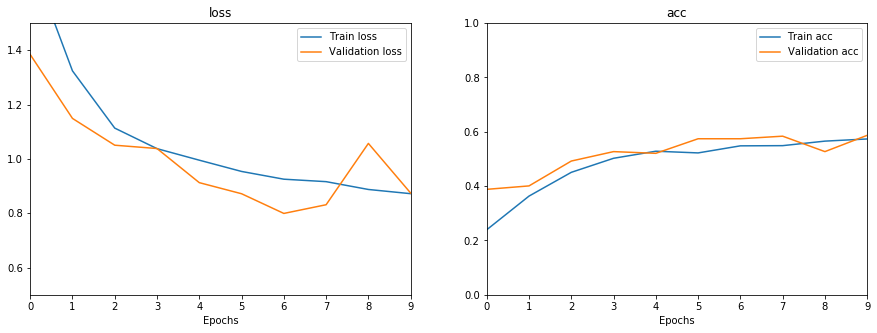

In [57]:
show_final_history(history)

In [60]:
model.evaluate(test_gen, verbose = 1)

400/400 [==============================] - 21s 52ms/step - loss: 0.9092 - acc: 0.6050


[0.9091785317915492, 0.605]